# Top 5 models tested at 20 epochs

## Imports and Data

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import models, datasets, transforms
from torch import nn, optim
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)), #resize the image to 224x224
    transforms.ToTensor(),  #convert the image to a pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize the image
])

Data for combined data

In [4]:

dataset = datasets.ImageFolder(root='./CombinedData', transform=data_transform)

class_names = dataset.classes

train_size = 0.70
val_size = 0.15
test_size = 0.15



# Split indices into training and combined validation/test indices
train_indices, val_test_indices = train_test_split(range(len(dataset)), test_size=(val_size + test_size), random_state=42)

# Split indices into validation and test indices
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_size/(val_size + test_size), random_state=42)

train_set = Subset(dataset, train_indices)  # Subset for training datata
test_set = Subset(dataset, test_indices)    # Subset for validation data given by teacher
val_set = Subset(dataset, val_indices)    # Subset for test data

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

## Model Functions

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [9]:
def trainModel(model, setepochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    custom_callback = CustomCallback()
    custom_callback.set_optimizer(optimizer)
    model.to(device)
    custom_callback.set_model(model)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)
    train_losses = []  # List to store training losses
    train_accuracies = []  # List to store training accuracies
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies

    # Training loop
    num_epochs = setepochs  # Number of epochs for training
    for epoch in range(num_epochs):
        # Training
        model.train()  # Set the model to training mode
        running_train_loss = 0.0  # Initialize running training loss
        correct_train = 0  # Initialize number of correctly predicted training samples
        total_train = 0  # Initialize total number of training samples
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize parameters

            running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_train += labels.size(0)  # Increment total training samples
            correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

        # Calculate epoch-wise training loss and accuracy
        epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
        train_accuracy = correct_train / total_train  # Training accuracy

        # Validation
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0  # Initialize running validation loss
        correct_val = 0  # Initialize number of correctly predicted validation samples
        total_val = 0  # Initialize total number of validation samples
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
                outputs = model(inputs)  # Forward pass
                if isinstance(outputs, tuple):
                    logits = outputs[0]  # Unpack logits if model returns tuple
                else:
                    logits = outputs
                loss = criterion(logits, labels)  # Calculate loss

                running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
                _, predicted = torch.max(logits, 1)  # Get predicted labels
                total_val += labels.size(0)  # Increment total validation samples
                correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

        # Calculate epoch-wise validation loss and accuracy
        epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
        val_accuracy = correct_val / total_val  # Validation accuracy

        # Append values to lists
        train_losses.append(epoch_train_loss)  # Append training loss
        train_accuracies.append(train_accuracy)  # Append training accuracy
        val_losses.append(epoch_val_loss)  # Append validation loss
        val_accuracies.append(val_accuracy)  # Append validation accuracy

        # Step LR scheduler
        lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

        # Check early stopping
        if custom_callback.on_epoch_end(epoch, epoch_val_loss):
            break  # Stop training if early stopping criterion is met

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Plot training and validation losses starting from index 1
    epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

    # Plot training and validation accuracies
    plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
    plt.xlabel('Epoch')  # Set label for the x-axis
    plt.ylabel('Accuracy')  # Set label for the y-axis
    plt.title('Training and Validation Accuracies')  # Set title for the plot
    plt.legend()  # Display legend
    plt.show()  # Show the plot
    # Plot training and validation losses starting from index 1
    epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

    # Plot training and validation losses
    plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
    plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
    plt.xlabel('Epoch')  # Set label for the x-axis
    plt.ylabel('Loss')  # Set label for the y-axis
    plt.title('Training and Validation Losses')  # Set title for the plot
    plt.legend()  # Display legend
    plt.grid(True)  # Display grid
    plt.show()  # Show the plot

In [10]:
def evalModel(model, criterion):
    model.eval()  # Set model to evaluation mode
    test_correct = 0  # Initialize number of correctly predicted samples
    test_total = 0  # Initialize total number of samples
    test_running_loss = 0.0  # Initialize running test loss

    with torch.no_grad():  # Turn off gradients during evaluation
        for inputs, labels in test_loader:  # Iterate through test data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)  # Get model predictions
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits from model outputs if necessary
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            test_total += labels.size(0)  # Update total number of samples
            test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

    # Calculate test loss and accuracy
    test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
    test_accuracy = test_correct / test_total  # Test accuracy

    # Print test results
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

## Swin_V2_t

##### Load Model

In [22]:
default_weight_swin_v2_t = models.Swin_V2_T_Weights.DEFAULT
swin_v2_t_model = models.swin_v2_t(weights=default_weight_swin_v2_t)

In [23]:
for param in swin_v2_t_model.parameters():
    param.requires_grad = False

In [24]:
num_features = swin_v2_t_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_swin_v2_t_model = swin_v2_t_model

tuned_swin_v2_t_model.head = new_head

In [25]:
print(tuned_swin_v2_t_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], Train Loss: 3.4058, Train Accuracy: 0.3706, Val Loss: 3.2470, Val Accuracy: 0.4923
Epoch [2/20], Train Loss: 3.1546, Train Accuracy: 0.5826, Val Loss: 3.1751, Val Accuracy: 0.5590
Epoch [3/20], Train Loss: 3.1230, Train Accuracy: 0.6089, Val Loss: 3.1602, Val Accuracy: 0.5709
Epoch [4/20], Train Loss: 3.1128, Train Accuracy: 0.6192, Val Loss: 3.1572, Val Accuracy: 0.5726
Epoch [5/20], Train Loss: 3.1010, Train Accuracy: 0.6320, Val Loss: 3.1296, Val Accuracy: 0.6000
Epoch [6/20], Train Loss: 3.0775, Train Accuracy: 0.6562, Val Loss: 3.1148, Val Accuracy: 0.6205
Epoch [7/20], Train Loss: 3.0391, Train Accuracy: 0.6968, Val Loss: 3.0781, Val Accuracy: 0.6564
Epoch [8/20], Train Loss: 3.0147, Train Accuracy: 0.7177, Val Loss: 3.0647, Val Accuracy: 0.6752
Epoch [9/20], Train Loss: 3.0086, Train Accuracy: 0.7254, Val Loss: 3.0524, Val Accuracy: 0.6821
Epoch [10/20], Train Loss: 3.0049, Train Accuracy: 0.7257, Val Loss: 3.0530, Val Accuracy: 0.6786
Epoch [11/20], Train Loss: 2.

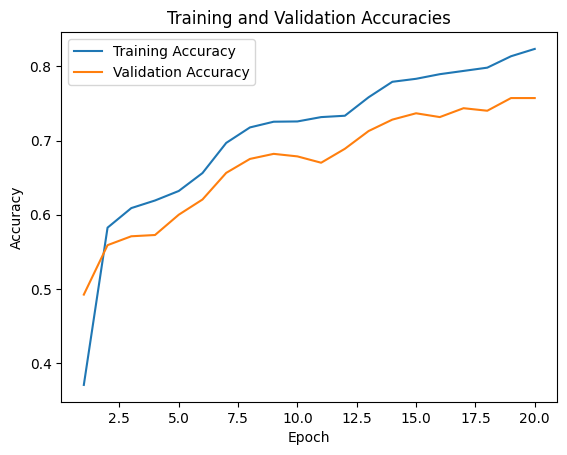

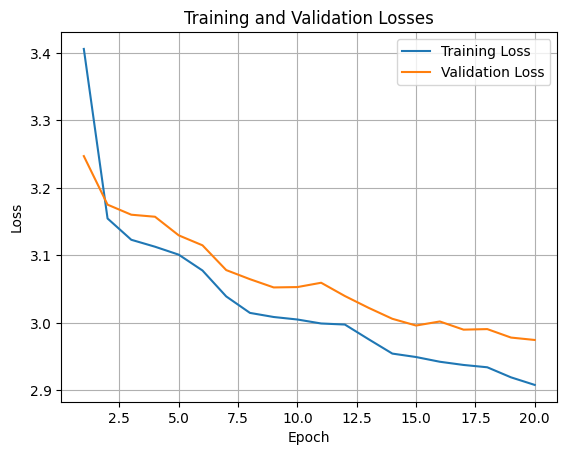

In [26]:
trainModel(tuned_swin_v2_t_model, 20)

In [27]:
evalModel(tuned_swin_v2_t_model, nn.CrossEntropyLoss())

Test Loss: 2.9541, Test Accuracy: 0.7765


## Vit_b_16

##### Load Model

In [28]:
default_weight_vit_b_16 = models.ViT_B_16_Weights.DEFAULT
vit_b_16_model = models.vit_b_16(weights=default_weight_vit_b_16)

In [29]:
for param in vit_b_16_model.parameters():
    param.requires_grad = False

In [30]:
num_features = vit_b_16_model.heads.head.in_features

new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_vit_b_16_model = vit_b_16_model

tuned_vit_b_16_model.heads = new_head

In [31]:
print(tuned_vit_b_16_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/20], Train Loss: 3.3281, Train Accuracy: 0.4555, Val Loss: 3.1548, Val Accuracy: 0.5897
Epoch [2/20], Train Loss: 3.0711, Train Accuracy: 0.6675, Val Loss: 3.1042, Val Accuracy: 0.6325
Epoch [3/20], Train Loss: 3.0180, Train Accuracy: 0.7162, Val Loss: 3.0687, Val Accuracy: 0.6667
Epoch [4/20], Train Loss: 2.9841, Train Accuracy: 0.7488, Val Loss: 3.0619, Val Accuracy: 0.6752
Epoch [5/20], Train Loss: 2.9795, Train Accuracy: 0.7536, Val Loss: 3.0435, Val Accuracy: 0.6872
Epoch [6/20], Train Loss: 2.9614, Train Accuracy: 0.7708, Val Loss: 3.0284, Val Accuracy: 0.7060
Epoch [7/20], Train Loss: 2.9567, Train Accuracy: 0.7748, Val Loss: 3.0226, Val Accuracy: 0.7145
Epoch [8/20], Train Loss: 2.9543, Train Accuracy: 0.7763, Val Loss: 3.0261, Val Accuracy: 0.7077
Epoch [9/20], Train Loss: 2.9529, Train Accuracy: 0.7781, Val Loss: 3.0338, Val Accuracy: 0.6991
Epoch [10/20], Train Loss: 2.9511, Train Accuracy: 0.7792, Val Loss: 3.0180, Val Accuracy: 0.7145
Epoch [11/20], Train Loss: 2.

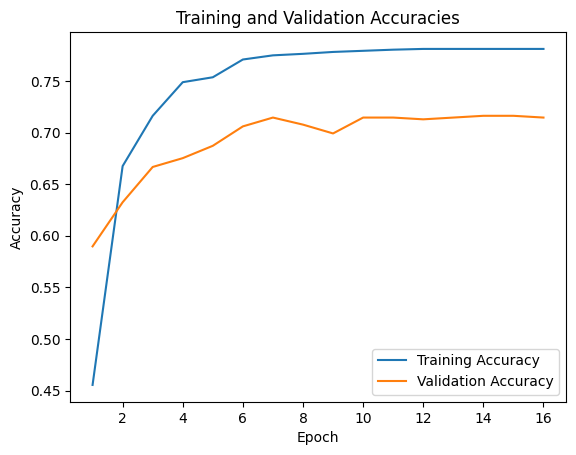

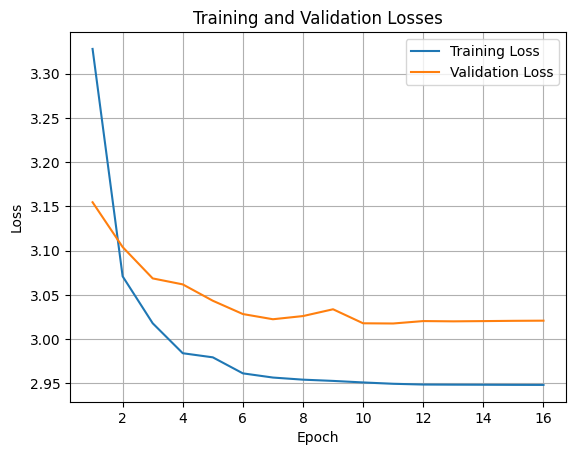

In [32]:
trainModel(tuned_vit_b_16_model, 20)

In [33]:
evalModel(tuned_vit_b_16_model, nn.CrossEntropyLoss())

Test Loss: 2.9942, Test Accuracy: 0.7440


## Vit_b_32

##### Load Model

In [34]:
default_weight_vit_b_32 = models.ViT_B_32_Weights.DEFAULT
vit_b_32_model = models.vit_b_32(weights=default_weight_vit_b_32)

In [35]:
for param in vit_b_32_model.parameters():
    param.requires_grad = False

In [36]:
num_features = vit_b_32_model.heads.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vit_b_32_model = vit_b_32_model

tuned_vit_b_32_model.heads = new_head

In [37]:
print(tuned_vit_b_32_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##### Training

Epoch [1/20], Train Loss: 3.3855, Train Accuracy: 0.3933, Val Loss: 3.1740, Val Accuracy: 0.5778
Epoch [2/20], Train Loss: 3.1380, Train Accuracy: 0.6038, Val Loss: 3.1311, Val Accuracy: 0.6085
Epoch [3/20], Train Loss: 3.0741, Train Accuracy: 0.6628, Val Loss: 3.0860, Val Accuracy: 0.6444
Epoch [4/20], Train Loss: 3.0427, Train Accuracy: 0.6891, Val Loss: 3.0810, Val Accuracy: 0.6479
Epoch [5/20], Train Loss: 3.0226, Train Accuracy: 0.7104, Val Loss: 3.0557, Val Accuracy: 0.6769
Epoch [6/20], Train Loss: 3.0071, Train Accuracy: 0.7235, Val Loss: 3.0688, Val Accuracy: 0.6684
Epoch [7/20], Train Loss: 3.0078, Train Accuracy: 0.7239, Val Loss: 3.0623, Val Accuracy: 0.6735
Epoch [8/20], Train Loss: 3.0009, Train Accuracy: 0.7301, Val Loss: 3.0637, Val Accuracy: 0.6701
Epoch [9/20], Train Loss: 2.9975, Train Accuracy: 0.7338, Val Loss: 3.0350, Val Accuracy: 0.6991
Epoch [10/20], Train Loss: 2.9933, Train Accuracy: 0.7382, Val Loss: 3.0426, Val Accuracy: 0.6906
Epoch [11/20], Train Loss: 2.

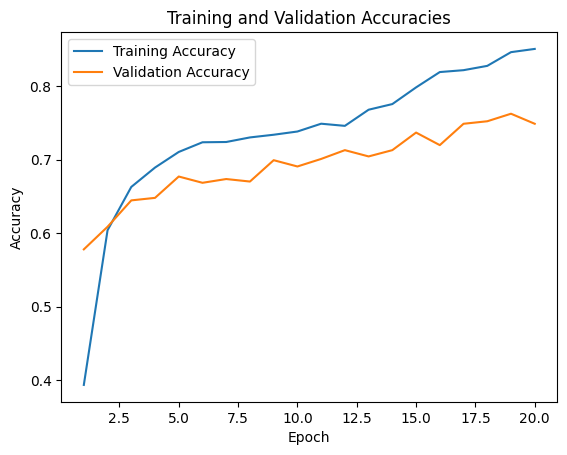

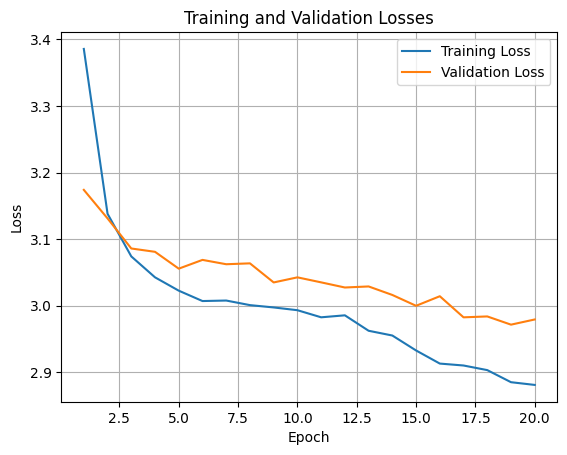

In [38]:
trainModel(tuned_vit_b_32_model, 20)

In [39]:
evalModel(tuned_vit_b_32_model, nn.CrossEntropyLoss())

Test Loss: 2.9639, Test Accuracy: 0.7662


## Swin_V2_b

##### Load Model

In [40]:
default_weight_swin_v2_b = models.Swin_V2_B_Weights.DEFAULT
swin_v2_b_model = models.swin_v2_b(weights=default_weight_swin_v2_b)

In [41]:
for param in swin_v2_b_model.parameters():
    param.requires_grad = False

In [42]:
num_features = swin_v2_b_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_swin_v2_b_model = swin_v2_b_model

tuned_swin_v2_b_model.head = new_head

In [43]:
print(tuned_swin_v2_b_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

##### Training

Epoch [1/20], Train Loss: 3.4243, Train Accuracy: 0.3519, Val Loss: 3.2166, Val Accuracy: 0.5350
Epoch [2/20], Train Loss: 3.1353, Train Accuracy: 0.6064, Val Loss: 3.1275, Val Accuracy: 0.6068
Epoch [3/20], Train Loss: 3.0657, Train Accuracy: 0.6745, Val Loss: 3.0572, Val Accuracy: 0.6821
Epoch [4/20], Train Loss: 3.0184, Train Accuracy: 0.7173, Val Loss: 3.0507, Val Accuracy: 0.6838
Epoch [5/20], Train Loss: 2.9946, Train Accuracy: 0.7389, Val Loss: 3.0322, Val Accuracy: 0.7026
Epoch [6/20], Train Loss: 2.9844, Train Accuracy: 0.7510, Val Loss: 3.0329, Val Accuracy: 0.7009
Epoch [7/20], Train Loss: 2.9742, Train Accuracy: 0.7591, Val Loss: 3.0115, Val Accuracy: 0.7231
Epoch [8/20], Train Loss: 2.9746, Train Accuracy: 0.7580, Val Loss: 3.0145, Val Accuracy: 0.7214
Epoch [9/20], Train Loss: 2.9627, Train Accuracy: 0.7693, Val Loss: 2.9958, Val Accuracy: 0.7368
Epoch [10/20], Train Loss: 2.9557, Train Accuracy: 0.7774, Val Loss: 2.9827, Val Accuracy: 0.7504
Epoch [11/20], Train Loss: 2.

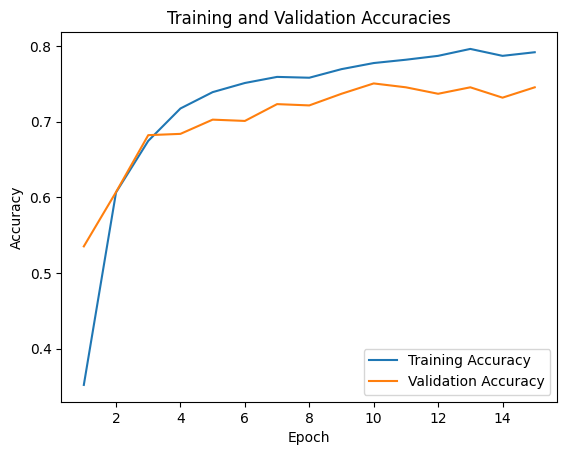

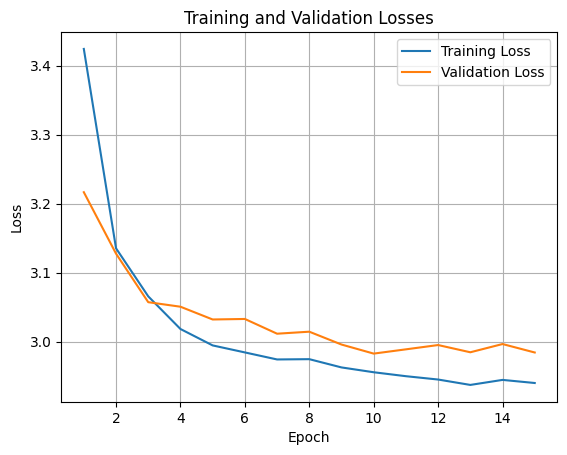

In [44]:
trainModel(tuned_swin_v2_b_model, 20)

In [45]:
evalModel(tuned_swin_v2_b_model, nn.CrossEntropyLoss())

Test Loss: 2.9533, Test Accuracy: 0.7765


## ConvNeXt Large

##### Load Model

In [11]:
default_weight_ConvNeXt_large = models.ConvNeXt_Large_Weights.DEFAULT
convnext_large_model = models.convnext_large(weights=default_weight_ConvNeXt_large)

In [12]:
#freeze all layers
for param in convnext_large_model.parameters():
    param.requires_grad = False

In [13]:
num_features = convnext_large_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_large_model = convnext_large_model

tuned_convnext_large_model.classifier[2] = new_head



In [14]:
print(tuned_convnext_large_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], Train Loss: 3.4283, Train Accuracy: 0.3435, Val Loss: 3.2478, Val Accuracy: 0.4872
Epoch [2/20], Train Loss: 3.2019, Train Accuracy: 0.5342, Val Loss: 3.1857, Val Accuracy: 0.5521
Epoch [3/20], Train Loss: 3.1541, Train Accuracy: 0.5782, Val Loss: 3.1782, Val Accuracy: 0.5538
Epoch [4/20], Train Loss: 3.1158, Train Accuracy: 0.6192, Val Loss: 3.1423, Val Accuracy: 0.5897
Epoch [5/20], Train Loss: 3.0644, Train Accuracy: 0.6675, Val Loss: 3.0835, Val Accuracy: 0.6479
Epoch [6/20], Train Loss: 3.0306, Train Accuracy: 0.7027, Val Loss: 3.0651, Val Accuracy: 0.6701
Epoch [7/20], Train Loss: 3.0074, Train Accuracy: 0.7250, Val Loss: 3.0514, Val Accuracy: 0.6855
Epoch [8/20], Train Loss: 3.0031, Train Accuracy: 0.7301, Val Loss: 3.0503, Val Accuracy: 0.6855
Epoch [9/20], Train Loss: 2.9831, Train Accuracy: 0.7492, Val Loss: 3.0453, Val Accuracy: 0.6923
Epoch [10/20], Train Loss: 2.9709, Train Accuracy: 0.7613, Val Loss: 3.0408, Val Accuracy: 0.6940
Epoch [11/20], Train Loss: 2.

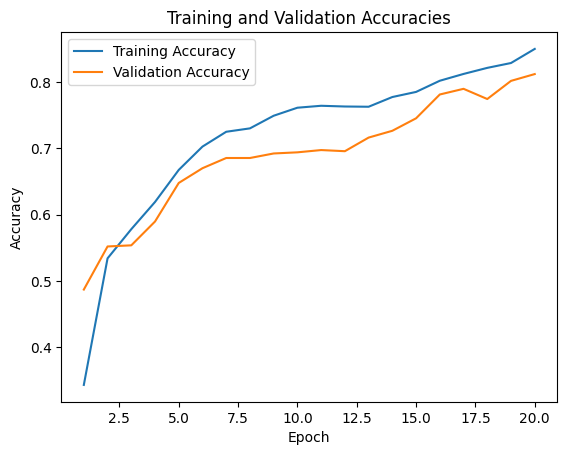

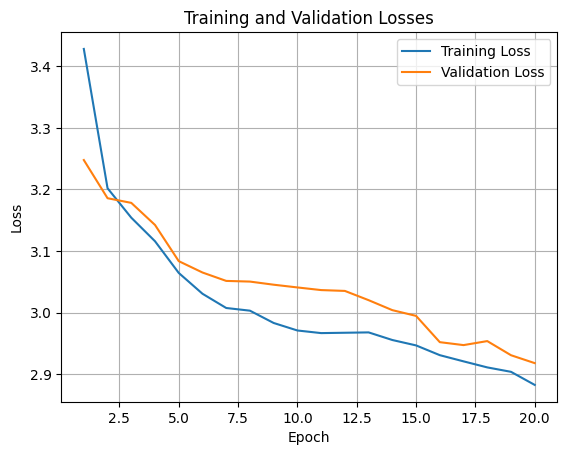

In [15]:
trainModel(tuned_convnext_large_model, 20)

In [16]:
evalModel(tuned_convnext_large_model, nn.CrossEntropyLoss())

Test Loss: 2.8946, Test Accuracy: 0.8362
